In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import numpy.ma as ma
from iris.util import broadcast_to_shape

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining function to merge cube list into single large cube
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [4]:
#defining function to merge cube list into single large cube
def time_reset_again(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        n+=1
    
    return 

In [5]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [6]:
#defining function to merge cube list into single large cube
def merge_cubes_again(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    for cube in cubes:
        new_cube = cube.copy()
        big_cube.append(new_cube)
    
    return big_cube.merge_cube()

In [7]:
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'

#loading in control, july, and january runs
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767'] 
january = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]


In [8]:
nino_constraint = iris.Constraint(longitude=lambda v: -170+360 <= v <= -120+360,latitude=lambda v: -5 <= v <= 5)

In [9]:
sat_july = iris.cube.CubeList()
for job_id in july:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[6:120]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_july.append(area_av)
    

In [10]:
sat_jan = iris.cube.CubeList()

    
for job_id in january:
    
    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[0:114]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_jan.append(area_av)

In [11]:
#Loading in control cubes - surface T extraction and area averaging done within loop
##CONTROL
control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0]
    enso = sst_control.extract(nino_constraint)
    area_av = area_average(enso)

    control.append(area_av)

In [12]:
time_reset(sat_july)
time_reset(sat_jan)
time_reset(control)

In [13]:
sat_merged_july = merge_cubes(sat_july)
sat_merged_jan = merge_cubes(sat_jan)
one_big_control = merge_cubes(control)

In [14]:
#Creating control ensemble average
mean_control = one_big_control.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [15]:
#Creating 10 year climatology
import iris.coord_categorisation
iris.coord_categorisation.add_month(mean_control,'time',name='month')
climatology_all_controls = mean_control.aggregated_by('month',iris.analysis.MEAN) 
climatology_long = np.tile(climatology_all_controls.data, 10)
climatology_short_1 = climatology_long[6:120]
climatology_short_2 = climatology_long[0:114]


In [16]:
anomally = one_big_control - climatology_long
anomally_cntl_july = anomally[:,6:120]
anomally_cntl_jan = anomally[:,0:114]

In [17]:

anomally_july = sat_merged_july - climatology_short_1.data

anomally_jan = sat_merged_jan - climatology_short_2.data

In [18]:
pertubation_july =  anomally_july - anomally_cntl_july.data

pertubation_jan =  anomally_jan - anomally_cntl_jan.data

In [19]:
#Taking ensemble mean anomalies for Jan and July
mean_pert_july = pertubation_july.collapsed('realization',iris.analysis.MEAN)
mean_pert_jan = pertubation_jan.collapsed('realization',iris.analysis.MEAN)

In [20]:
time = range(0,114)

zero = []

for i in range(0,114):
    i = 0
    zero.append(i)

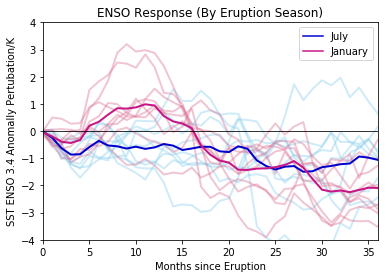

In [21]:
from matplotlib.lines import Line2D

for cube in pertubation_july.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='skyblue', alpha = 0.4, lw=2)#plotting mean

for cube in pertubation_jan.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='palevioletred', alpha = 0.4, lw=2)#plotting mean
    
plt.plot(time, mean_pert_july.data, color='mediumblue',lw=2)
plt.plot(time, mean_pert_jan.data, color='mediumvioletred',lw=2)

plt.plot(time, zero, color='black', lw = 1, linestyle='-', alpha = 0.8)

plt.xlabel('Months since Eruption')
plt.ylabel('SST ENSO 3.4 Anomally Pertubation/K')
plt.xlim(time[0],time[36])
plt.ylim(-4,4)
july_line = Line2D([0], [0], label='July', color='mediumblue')
jan_line = Line2D([0], [0], label='January', color='mediumvioletred')
plt.legend(handles=[july_line, jan_line])
plt.title('ENSO Response (By Eruption Season)')

plt.savefig('ENSO_pertubation_by_timing.pdf')